## Import

In [1]:
!pip3 install pyflann-py3

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -p pytransform3d,matplotlib,scipy,numpy,pyflann
# %watermark -p numpy,sklearn,pandas
# %watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
# %watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
# %config IPCompleter.use_jedi = False

%matplotlib inline
# %matplotlib widget
# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np
import scipy.io as sio

np.set_printoptions(
    edgeitems=3, infstr='inf',
    linewidth=75, nanstr='nan', precision=6,
    suppress=True, threshold=100, formatter=None)

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x, tag='main', debug=False):
    def __request_text(url):
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            raise RuntimeError(url)
    try:
        x = x.strip()
        if x[0] == '/' or x[1] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                x = 'https://' + x
                x = __request_text(x)
            elif x.startswith('github.com'):
                x = x.replace('github.com', 'raw.githubusercontent.com')
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/{tag}/' + '/'.join(mod[-3:])
                x = __request_text(x)
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/raw/{tag}/' + '/'.join(mod[3:])
                x = __request_text(x)
        if debug:
            return x
        else:
            exec(x, globals())
    except Exception as err:
        # sys.stderr.write(f'request {x} : {err}')
       pass

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)


###
### Display ###
###

_IMPORT('import pandas as pd')
_IMPORT('import cv2')
_IMPORT('from PIL import Image')
_IMPORT('import matplotlib.pyplot as plt')
# _IMPORT('import plotly')
# _IMPORT('import plotly.graph_objects as go')
# _IMPORT('import ipywidgets as widgets')
# _IMPORT('from ipywidgets import interact, interactive, fixed, interact_manual')
_IMPORT('import pytransform3d.rotations')
_IMPORT('import pytransform3d.camera')
_IMPORT('import pytransform3d.transformations')
_IMPORT('import pyflann')
# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)
# from matplotlib.font_manager import FontProperties
# simsun = FontProperties(fname='/sysfonts/simsun.ttc', size=12)

    
def show_image(imgsrc, width=None, height=None, rgb=True):
    if isinstance(imgsrc, np.ndarray):
        plt.close('all')
        img = imgsrc
        if width or height:
            if width and height:
                size = (width, height)
            else:
                rate = img.shape[1] / img.shape[0]
                if width:
                    size = (width, int(width/rate))
                else:
                    size = (int(height*rate), height)
            img = cv2.resize(img, size)
            plt.figure(figsize=(3*int(size[0]/80+1), 3*int(size[1]/80+1)), dpi=80)
        plt.axis('off')
        if len(img.shape) > 2:
            if not rgb:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img);
        else:
            plt.imshow(img, cmap='gray');
        return

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if imgsrc.startswith('http'):
        data_url = imgsrc
    else:
        if len(imgsrc) > 2048:
            data_url = 'data:image/jpg;base64,' + imgsrc
        else:
            img = open(imgsrc, 'rb').read()
            data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<center><img %s %s src="%s"/></center>' % (W, H, data_url))

pytransform3d: 3.4.0
matplotlib   : 3.5.1
scipy        : 1.8.0
numpy        : 1.22.3
pyflann      : unknown



## Global

In [3]:
TOP_DIR='/jupyter/hzcsbet/gamebet'
H = 720
W = 1280

class COLORS(object):
    # BGR
    GREEN      = (0   , 255 , 0)
    RED        = (0   , 0   , 255)
    BLACK      = (0   , 0   , 0)
    YELLOW     = (0   , 255 , 255)
    WHITE      = (255 , 255 , 255)
    CYAN       = (255 , 255 , 0)
    MAGENTA    = (255 , 0   , 242)
    GOLDEN     = (32  , 218 , 165)
    LIGHT_BLUE = (255 , 9   , 2)
    PURPLE     = (128 , 0   , 128)
    CHOCOLATE  = (30  , 105 , 210)
    PINK       = (147 , 20  , 255)
    ORANGE     = (0   , 69  , 255)

sys.path.append(f'{TOP_DIR}/python')

import cv2 as cv

In [4]:
def _print_dictkeys_shape(d):
    for k, v in d.items():
        if k.startswith('__'):
            continue
        print(f'{k}: {v.shape}')
        
def _print_statistics(o, prefix=''):
    if isinstance(o, np.ndarray):
        print(f'{prefix} mean: {o.mean()}, std: {o.std()}, max: {o.max()}, min:{o.min()}')
    
def _print_matrix(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
_print_star = lambda n = 50: print('*' * n)

In [5]:
def _imshow(image, color='gray', figsize=(6, 3)):
    plt.close('all')
    plt.figure(figsize=figsize)
    plt.axis('off')
    if color == 'gray':
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Dataset

### worldcup2014.mat

In [6]:
worldcup_2014_mat = sio.loadmat(f'{TOP_DIR}/data/worldcup2014.mat')
_print_dictkeys_shape(worldcup_2014_mat)

points: (302, 2)
line_segment_index: (151, 2)
grid_points: (2204, 2)


In [7]:
points = worldcup_2014_mat['points']
_print_statistics(points[:, 0], 'points'), _print_statistics(points[:, 1], 'points');

points mean: 52.50027599999999, std: 27.479935120360008, max: 105.000552, min:0.0
points mean: 34.001964, std: 11.397408419732242, max: 68.003928, min:0.0


(69, 106, 3)

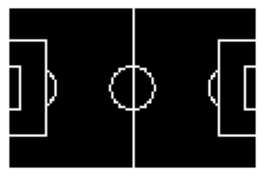

In [8]:
w, h = int(np.ceil(points[:, 0].max())), int(np.ceil(points[:, 1].max()))
img_soccer_field = np.zeros((h, w, 3), dtype=np.uint8)
for idx1, idx2 in worldcup_2014_mat['line_segment_index']:
    p1, p2 = points[idx1], points[idx2]
    q1 = np.rint(p1).astype(np.int32)
    q2 = np.rint(p2).astype(np.int32)
    cv2.line(img_soccer_field, tuple(q1), tuple(q2), COLORS.WHITE)
    
_imshow(img_soccer_field)
img_soccer_field.shape

### worldcup_dataset_camera_parameter.mat

In [9]:
worldcup_camera_parameter = sio.loadmat(f'{TOP_DIR}/data/worldcup_dataset_camera_parameter.mat')
_print_dictkeys_shape(worldcup_camera_parameter)

cc_max: (1, 3)
cc_mean: (1, 3)
cc_min: (1, 3)
cc_std: (1, 3)
fl_max: (1, 1)
fl_mean: (1, 1)
fl_min: (1, 1)
fl_std: (1, 1)


### worldcup_sampled_cameras.mat

In [10]:
worldcup_sampled_cameras = sio.loadmat(f'{TOP_DIR}/data/worldcup_sampled_cameras.mat')
_print_dictkeys_shape(worldcup_sampled_cameras)

pivot_cameras: (91173, 9)
positive_cameras: (91173, 9)
positive_ious: (91173, 1)


In [11]:
worldcup_sampled_cameras['pivot_cameras'][12:18]

array([[ 640.      ,  360.      , 3854.144927,    1.6884  ,    0.243943,
          -0.213464,   51.974747,  -53.391455,   15.158311],
       [ 640.      ,  360.      , 4992.664677,    1.724868,   -0.236567,
           0.192668,   58.227037,  -43.640134,   13.287872],
       [ 640.      ,  360.      , 2918.389825,    1.736694,    0.138454,
          -0.111589,   48.270506,  -47.907207,   14.251457],
       [ 640.      ,  360.      , 3604.84738 ,    1.772747,   -0.022877,
           0.008633,   53.119063,  -41.81307 ,   14.684627],
       [ 640.      ,  360.      , 2797.713665,    1.656788,   -0.239269,
           0.21015 ,   52.201609,  -43.969138,   13.911572],
       [ 640.      ,  360.      , 4022.714545,    1.738111,   -0.151789,
           0.134468,   53.14781 ,  -47.103762,   12.389078]])

### features/database_camera_feature.mat

In [12]:
database_camera_features = sio.loadmat(f'{TOP_DIR}/data/features/database_camera_feature.mat')
_print_dictkeys_shape(database_camera_features)

cameras: (91173, 9)
features: (91173, 16)


In [13]:
database_camera_features['cameras'][:5]

array([[ 640.      ,  360.      , 1843.086214,    1.668861,    0.237341,
          -0.216936,   51.725313,  -55.24253 ,   13.741604],
       [ 640.      ,  360.      , 2735.760138,    1.683446,   -0.439934,
           0.380944,   55.36815 ,  -47.510307,   15.00194 ],
       [ 640.      ,  360.      , 2636.988208,    1.710394,    0.35452 ,
          -0.30104 ,   50.968008,  -56.355524,   13.276288],
       [ 640.      ,  360.      , 1969.785521,    1.639676,    0.421219,
          -0.381463,   49.688613,  -27.465165,   17.864562],
       [ 640.      ,  360.      , 2702.236468,    1.786187,   -0.126308,
           0.106665,   49.974861,  -54.884818,   16.401735]])

In [14]:
# calculate from siamese neural network
database_camera_features['features'][:5]

array([[-0.372055, -0.09087 , -0.259755, -0.208958,  0.21655 , -0.135903,
         0.207431,  0.185724, -0.221791,  0.125692,  0.043995,  0.469147,
        -0.093933,  0.227581,  0.495774,  0.076366],
       [ 0.267115,  0.11651 , -0.386815, -0.154943, -0.17079 , -0.271643,
         0.10116 , -0.144005,  0.252797,  0.299399,  0.400056, -0.09353 ,
         0.089256,  0.375996,  0.236919,  0.282277],
       [ 0.646169, -0.152043, -0.403935, -0.07253 , -0.016389, -0.004778,
        -0.090194, -0.087009,  0.240885,  0.287335,  0.152687,  0.284175,
        -0.30157 , -0.012018, -0.123235, -0.154816],
       [-0.115721, -0.269547,  0.277795, -0.260665, -0.022519,  0.030737,
        -0.107026, -0.235174,  0.190954,  0.126271, -0.248658, -0.424408,
         0.493188,  0.300325,  0.230555,  0.140185],
       [ 0.297994,  0.317869,  0.033043, -0.257077, -0.295638, -0.128306,
         0.220009, -0.255847,  0.546875, -0.143696,  0.195117,  0.130659,
         0.278087, -0.027115,  0.259274, -0.0712

### features/testset_feature.mat

In [15]:
testset_features = sio.loadmat(f'{TOP_DIR}/data/features/testset_feature.mat')
_print_dictkeys_shape(testset_features)

edge_distances: (180, 320, 1, 186)
edge_map: (720, 1280, 1, 186)
features: (16, 186)


In [16]:
# calculate by cv.distanceTransform
show_num = 4
edge_distances_x = testset_features["edge_distances"][..., :show_num]
edge_distances_x.shape

(180, 320, 1, 4)

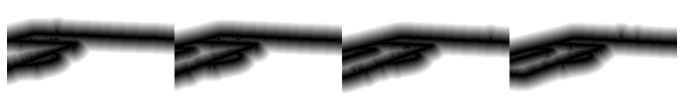

In [17]:
_imshow(np.hstack(np.split(edge_distances_x, indices_or_sections=show_num, axis=-1)).squeeze(), color='gray', figsize=(3 * show_num, 2))

In [19]:
show_num = 4
edge_map_x = testset_features["edge_map"][..., :show_num]
edge_map_x.shape

(720, 1280, 1, 4)

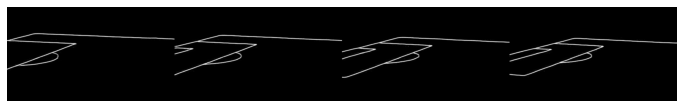

In [20]:
_imshow(np.hstack(np.split(edge_map_x, indices_or_sections=show_num, axis=-1)).squeeze(), color='gray', figsize=(3 * show_num, 2))

### UoT_soccer/train_val.mat

In [24]:
train_val_UoT = sio.loadmat(f'{TOP_DIR}/data/UoT_soccer/train_val.mat')
_print_dictkeys_shape(train_val_UoT)

annotation: (1, 209)
meta: (1, 1)


In [25]:
train_val_UoT['meta']

array([[(array(['train_val'], dtype='<U9'), array(['/Users/jimmy/Desktop/images/UoT_soccer/train_val'], dtype='<U48'))]],
      dtype=[('data_type', 'O'), ('folder', 'O')])

In [26]:
type(train_val_UoT['annotation'][0][0]), train_val_UoT['annotation'][0][0]

(numpy.void,
 (array(['1.jpg'], dtype='<U5'), array([[ -1.21252 ,   0.032872,  64.237605],
        [ -0.004756,   0.009247, -19.363899],
        [ -0.000126,   0.000496,  -0.053625]])))

In [27]:
train_val_UoT['annotation'][0][15:17]

array([(array(['16.jpg'], dtype='<U6'), array([[   9.964002,    1.539575, -775.332768],
              [  -0.422633,    0.694584,  152.285376],
              [   0.000789,   -0.003297,    0.401312]]))                               ,
       (array(['17.jpg'], dtype='<U6'), array([[   8.145961,    1.639647, -688.687658],
              [  -0.217398,    0.451414,  126.647341],
              [   0.001019,   -0.002626,    0.2949  ]]))                               ],
      dtype=[('image_name', 'O'), ('homography', 'O')])

In [28]:
h16_gt_mat = sio.loadmat(f'{TOP_DIR}/data/UoT_soccer/16_grass_gt.mat')
_print_dictkeys_shape(h16_gt_mat)

grass: (720, 1280)


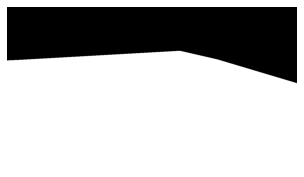

In [29]:
_imshow(h16_gt_mat['grass'], 'gray')

### UoT_soccer/test.mat (same size with testset_feature.mat)

In [30]:
test_UoT = sio.loadmat(f'{TOP_DIR}/data/UoT_soccer/test.mat')
_print_dictkeys_shape(test_UoT)

annotation: (1, 186)
meta: (1, 1)


In [31]:
test_UoT['annotation'][0][15:17]

array([(array(['16.jpg'], dtype='<U6'), array([[ 11.11628 ,  -6.766282, 188.062353],
              [  0.440481,   0.381525, 127.388439],
              [ -0.000302,  -0.003024,   0.402609]]))                               ,
       (array(['17.jpg'], dtype='<U6'), array([[   1.878536,   -0.059891, -100.151941],
              [  -0.030807,    0.022421,   28.215382],
              [   0.000111,   -0.000737,    0.08457 ]]))                               ],
      dtype=[('image_name', 'O'), ('homography', 'O')])

## Plot3D

In [32]:
worldcup_camera_parameter

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Jan 29 09:43:18 2018',
 '__version__': '1.0',
 '__globals__': [],
 'cc_max': array([[ 60.845633, -16.741782,  23.011261]]),
 'cc_mean': array([[ 52.366185, -45.156501,  16.821567]]),
 'cc_min': array([[ 45.056791, -66.070204,  10.138713]]),
 'cc_std': array([[2.231926, 9.382564, 2.948753]]),
 'fl_max': array([[5696.984549]]),
 'fl_mean': array([[3018.181398]]),
 'fl_min': array([[1463.164684]]),
 'fl_std': array([[716.068171]])}

(array([[ 0.996195, -0.      , -0.087156],
        [ 0.087156,  0.      ,  0.996195],
        [ 0.      , -1.      ,  0.      ]]),
 array([ 52.366185, -45.156501,  16.821567]))

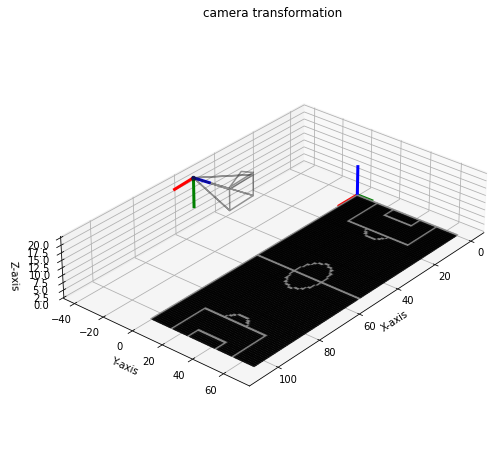

In [33]:
img_soccer = cv2.cvtColor(img_soccer_field, cv2.COLOR_BGR2RGB)
img_soccer = np.transpose(img_soccer, (1, 0, 2))

plt.close('all')
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set(xlim=(-5, img_soccer.shape[0] + 5), ylim=(-45, img_soccer.shape[1] + 5), zlim=(0, 20))
ax = pytransform3d.rotations.plot_basis(
    ax,
    s=10, # 基坐标大小
    lw=3,
)

Rx_neg_90 = pytransform3d.rotations.active_matrix_from_angle(0, np.deg2rad(-90))
Ry_pos_00 = pytransform3d.rotations.active_matrix_from_angle(1, np.deg2rad(0))
Rz_pos_05 = pytransform3d.rotations.active_matrix_from_angle(2, np.deg2rad(5))
# R = pytransform3d.rotations.active_matrix_from_extrinsic_euler_xyz((np.deg2rad(-90), 0, np.deg2rad(5)))
R_c = Rz_pos_05 @ Ry_pos_00 @ Rx_neg_90 
C = worldcup_camera_parameter['cc_mean'][0]
ax = pytransform3d.rotations.plot_basis(
    ax,
    s=10, lw=3,
    R=R_c,
    p=C,
    # label='Camera PTZ'
)
xx, yy = np.ogrid[0:img_soccer.shape[0], 0:img_soccer.shape[1]]
# 设置x,y,z坐标轴刻度等大小
ax.set_box_aspect((np.ptp(xx), np.ptp(yy), 20))
ax.plot_surface(xx, yy, np.atleast_2d(0), alpha=0.75, rstride=1, cstride=1, facecolors=img_soccer.astype(np.float32) / 255.0)

# Camera
f = worldcup_camera_parameter['fl_mean'][0][0]
sensor_size = (1280, 720)
intrinsic_matrix = np.array([
    [f, 0, sensor_size[0] / 2],
    [0, f, sensor_size[1] / 2],
    [0, 0, 1.0]
], dtype=np.float32)

# H(p) @ H(R)
cam2world = pytransform3d.transformations.transform_from(R=R_c, p=C)
pytransform3d.camera.plot_camera(
    ax=ax,
    cam2world=cam2world,
    M=intrinsic_matrix, 
    sensor_size=sensor_size, # TODO
    virtual_image_distance=30,
    alpha=0.45, color='#181818'
)
ax.view_init(elev=30, azim=40, vertical_axis='z')
ax.set_title("camera transformation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
R_c, C

### Camera Pose

Let $C$ be a column vector describing the location of the camera-center in world coordinates, and let $R_c$
be the rotation matrix describing the camera's orientation with respect to the world coordinate axes.

In [34]:
R_h = np.eye(4)
R_h[:3, :3] = R_c
R_h

array([[ 0.996195, -0.      , -0.087156,  0.      ],
       [ 0.087156,  0.      ,  0.996195,  0.      ],
       [ 0.      , -1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  1.      ]])

In [35]:
C_h = np.eye(4)
C_h[:3, -1] = C
C_h

array([[  1.      ,   0.      ,   0.      ,  52.366185],
       [  0.      ,   1.      ,   0.      , -45.156501],
       [  0.      ,   0.      ,   1.      ,  16.821567],
       [  0.      ,   0.      ,   0.      ,   1.      ]])

In [36]:
Pose = C_h @ R_h
Pose

array([[  0.996195,  -0.      ,  -0.087156,  52.366185],
       [  0.087156,   0.      ,   0.996195, -45.156501],
       [  0.      ,  -1.      ,   0.      ,  16.821567],
       [  0.      ,   0.      ,   0.      ,   1.      ]])

In [37]:
Pose.T, np.linalg.inv(Pose)

(array([[  0.996195,   0.087156,   0.      ,   0.      ],
        [ -0.      ,   0.      ,  -1.      ,   0.      ],
        [ -0.087156,   0.996195,   0.      ,   0.      ],
        [ 52.366185, -45.156501,  16.821567,   1.      ]]),
 array([[  0.996195,   0.087156,   0.      , -48.231267],
        [ -0.      ,   0.      ,  -1.      ,  16.821567],
        [ -0.087156,   0.996195,   0.      ,  49.548681],
        [  0.      ,   0.      ,   0.      ,   1.      ]]))

### Camera Extrinsic

Describes how to transform points in world coordinates to camera coordinates. The vector $t$ can be interpreted as the position of the world origin in camera coordinates, and the columns of $R$ represent represent the directions of the world-axes in camera coordinates.

The extrinsic matrix is obtained by inverting the camera's pose matrix.

In [38]:
R = R_c.T
t = -R_c.T @ C
R, t

(array([[ 0.996195,  0.087156,  0.      ],
        [-0.      ,  0.      , -1.      ],
        [-0.087156,  0.996195,  0.      ]]),
 array([-48.231267,  16.821567,  49.548681]))

In [ ]:
raise

## Search Feature

In [44]:
query_index = 15
struct_void = test_UoT['annotation'][0][query_index]
type(struct_void), struct_void['image_name'], struct_void['homography']

(numpy.void,
 array(['16.jpg'], dtype='<U6'),
 array([[ 11.11628 ,  -6.766282, 188.062353],
        [  0.440481,   0.381525, 127.388439],
        [ -0.000302,  -0.003024,   0.402609]]))

In [45]:
# ground truth homography
test_image_name, test_gt_h = struct_void
test_image_name, test_gt_h

(array(['16.jpg'], dtype='<U6'),
 array([[ 11.11628 ,  -6.766282, 188.062353],
        [  0.440481,   0.381525, 127.388439],
        [ -0.000302,  -0.003024,   0.402609]]))

In [46]:
testset_features['features'].shape, database_camera_features['features'].shape

((16, 186), (91173, 16))

In [47]:
database_features, testset_feature_x = database_camera_features['features'], testset_features['features'][:, query_index]
testset_feature_x

array([ 0.025688, -0.233451, -0.096971, -0.20187 , -0.0677  ,  0.410727,
       -0.082704,  0.275503,  0.354157,  0.520592,  0.193371,  0.137005,
        0.227932, -0.352738, -0.097878,  0.008252], dtype=float32)

In [48]:
# %%timeit

# get the similar camera feature from feature database
flann = pyflann.FLANN()
result, _ = flann.nn(database_features, testset_feature_x, 1, algorithm="kdtree", trees=8, checks=64)
result

array([74009], dtype=int32)

In [49]:
retrieved_camera_param = database_camera_features['cameras'][result[0]]
retrieved_camera_param

array([ 640.      ,  360.      , 4444.471781,    1.674882,    0.29559 ,
         -0.259898,   51.736009,  -54.392403,   14.967156])

(None,
 array([ 640.      ,  360.      , 4444.471781,    1.674882,    0.29559 ,
          -0.259898,   51.736009,  -54.392403,   14.967156]))

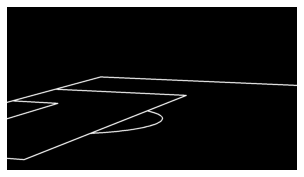

In [50]:
retrieved_image = SyntheticUtil.camera_to_edge_image(
    retrieved_camera_param, worldcup_2014_mat['points'], worldcup_2014_mat['line_segment_index'],
    im_h=720, im_w=1280, line_width=4)

_imshow(retrieved_image), retrieved_camera_param

(None,
 array([ 0.025688, -0.233451, -0.096971, -0.20187 , -0.0677  ,  0.410727,
        -0.082704,  0.275503,  0.354157,  0.520592,  0.193371,  0.137005,
         0.227932, -0.352738, -0.097878,  0.008252], dtype=float32))

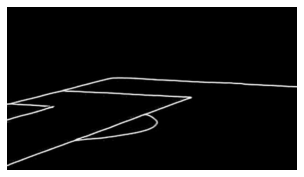

In [51]:
_imshow(testset_features['edge_map'][..., query_index]), testset_features['features'][..., query_index]

In [52]:
_print_dictkeys_shape(worldcup_2014_mat)

points: (302, 2)
line_segment_index: (151, 2)
grid_points: (2204, 2)


In [53]:
_print_dictkeys_shape(testset_features)

edge_distances: (180, 320, 1, 186)
edge_map: (720, 1280, 1, 186)
features: (16, 186)


## Utils

In [ ]:
img = cv2.imread(f'{TOP_DIR}/data/16_edge_image.jpg')
show_image(img)

In [ ]:
img = cv2.cvtColor(img, cv.COLOR_BGR2GRAY)
show_image(img)

In [ ]:
_, binary_im = cv2.threshold(img, 10, 255, cv.THRESH_BINARY_INV)
show_image(binary_im)

In [ ]:
dist_im = cv2.distanceTransform(binary_im, cv.DIST_L2, cv.DIST_MASK_PRECISE)
dist_im[dist_im > 255] = 255
dist_im = dist_im.astype(np.uint8)
show_image(dist_im)

In [ ]:
dist_im.max()

In [ ]:
train_sample_data = sio.loadmat('./worldcup_sampled_cameras.mat')

In [ ]:
train_sample_data.keys()

In [ ]:
train_sample_data['pivot_cameras'].shape, train_sample_data['positive_cameras'].shape, train_sample_data['positive_ious'].shape

In [ ]:
for i in range(10000, 10100, 10):
    pivot = train_sample_data['pivot_cameras'][i]
    print(pivot.tolist())

In [ ]:
for i in range(10000, 10100, 10):
    pivot = train_sample_data['positive_cameras'][i]
    print(pivot.tolist())

In [ ]:
train_sample_data['positive_cameras'][0]

## Last


$$
(A @ B)^T = B^T @ A^T
$$

### A

In [39]:
class RotationUtil:
    @staticmethod
    def rotate_x_axis(angle):
        """
        rotate coordinate with X axis
        https://en.wikipedia.org/wiki/Rotation_matrix + transpose
        http://mathworld.wolfram.com/RotationMatrix.html
        :param angle: in degree
        :return:
        """
        angle = math.radians(angle)
        s = math.sin(angle)
        c = math.cos(angle)

        r = np.asarray([[1, 0, 0],
                        [0, c, -s],
                        [0, s, c]])
        r = np.transpose(r)
        return r

    @staticmethod
    def rotate_y_axis(angle):
        """
        rotate coordinate with X axis
        :param angle:
        :return:
        """
        angle = math.radians(angle)
        s = math.sin(angle)
        c = math.cos(angle)

        r = np.asarray([[c, 0, s],
                        [0, 1, 0],
                        [-s, 0, c]])
        r = np.transpose(r)
        return r

    @staticmethod
    def rotate_z_axis(angle):
        """

        :param angle:
        :return:
        """
        angle = math.radians(angle)
        s = math.sin(angle)
        c = math.cos(angle)

        r = np.asarray([[c, -s, 0],
                        [s, c, 0],
                        [0, 0, 1]])
        r = np.transpose(r)
        return r

    @staticmethod
    def pan_y_tilt_x(pan, tilt):
        """
        Rotation matrix of first pan, then tilt
        :param pan:
        :param tilt:
        :return:
        """
        r_tilt = RotationUtil.rotate_x_axis(tilt)
        r_pan = RotationUtil.rotate_y_axis(pan)
        m = r_tilt @ r_pan
        return m

    #  rot_vec, _ = cv.Rodrigues(rotation)
    @staticmethod
    def rotation_matrix_to_Rodrigues(m):
        assert m.shape[0] == 3 and m.shape[1] == 3
        rot_vec, _ = cv.Rodrigues(m)
        return rot_vec

In [40]:
class ProjectiveCamera:
    def __init__(self, fl, u, v, cc, rod_rot):
        """
        :param fl:
        :param u:
        :param v:
        :param cc:
        :param rod_rot:
        """
        self.K = np.zeros((3, 3)) # calibration matrix
        self.camera_center = np.zeros(3)
        self.rotation = np.zeros(3)

        self.P = np.zeros((3, 4)) # projection matrix

        self.set_calibration(fl, u, v)
        self.set_camera_center(cc)
        self.set_rotation(rod_rot)

    def set_calibration(self, fl, u, v):
        """
        :param fl:
        :param u:
        :param v:
        :return:
        """
        self.K = np.asarray([[fl, 0, u],
                             [0, fl, v],
                             [0, 0, 1]])
        self._recompute_matrix()

    def set_camera_center(self, cc):
        assert cc.shape[0] == 3

        self.camera_center[0] = cc[0]
        self.camera_center[1] = cc[1]
        self.camera_center[2] = cc[2]
        self._recompute_matrix()

    def set_rotation(self, rod_rot):
        """
        :param rod_rot: Rodrigues vector
        :return:
        """
        assert rod_rot.shape[0] == 3

        self.rotation[0] = rod_rot[0]
        self.rotation[1] = rod_rot[1]
        self.rotation[2] = rod_rot[2]
        self._recompute_matrix()

    def project_3d(self, x, y, z, w=1.0):
        """
        :param x:
        :param y:
        :param z:
        :return:
        """
        p = np.zeros(4)
        p[0],p[1],p[2], p[3] = x, y, z, w
        q = self.P @ p
        assert q[2] != 0.0
        return (q[0]/q[2], q[1]/q[2])

    def get_homography(self):
        """
        homography matrix from the projection matrix
        :return:
        """
        h = self.P[:, [0, 1,3]]
        return h


    def _recompute_matrix(self):
        """
        :return:
        """
        P = np.zeros((3, 4))
        for i in range(3):
            P[i][i] = 1.0

        for i in range(3):
            P[i][3] = -self.camera_center[i]

        r, _ = cv.Rodrigues(self.rotation)
        #print(r)
        #print('{} {} {}'.format(self.K.shape, r.shape, P.shape))
        self.P = self.K @ r @ P

In [41]:
class SyntheticUtil:
    @staticmethod
    def camera_to_edge_image(camera_data,
                             model_points, model_line_segment,
                             im_h=720, im_w=1280, line_width=4):
        """
         Project (line) model images using the camera
        :param camera_data: 9 numbers
        :param model_points:
        :param model_line_segment:
        :param im_h: 720
        :param im_w: 1280
        :return: H * W * 3 OpenCV image
        """
        assert camera_data.shape[0] == 9

        u, v, fl = camera_data[0:3]
        rod_rot = camera_data[3:6]
        cc = camera_data[6:9]

        camera = ProjectiveCamera(fl, u, v, cc, rod_rot)
        im = np.zeros((im_h, im_w, 3), dtype=np.uint8)
        n = model_line_segment.shape[0]
        color = (255, 255, 255)
        for i in range(n):
            idx1, idx2 = model_line_segment[i][0], model_line_segment[i][1]
            p1, p2 = model_points[idx1], model_points[idx2]
            q1 = camera.project_3d(p1[0], p1[1], 0.0, 1.0)
            q2 = camera.project_3d(p2[0], p2[1], 0.0, 1.0)
            q1 = np.rint(q1).astype(np.int32)
            q2 = np.rint(q2).astype(np.int32)
            cv.line(im, tuple(q1), tuple(q2), color, thickness=line_width)
        return im

    @staticmethod
    def distance_transform(img):
        """
        :param img: OpenCV Image
        :return:
        """
        h, w, c = img.shape
        if c == 3:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            assert c == 1

        _, binary_im = cv.threshold(img, 10, 255, cv.THRESH_BINARY_INV)

        dist_im = cv.distanceTransform(
            binary_im, cv.DIST_L2, cv.DIST_MASK_PRECISE)
        return dist_im

    @staticmethod
    def find_transform(im_src, im_dst):
        warp = np.eye(3, dtype=np.float32)
        criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 50, 0.001)
        # suggested by felibol
        # https://github.com/lood339/SCCvSD/issues/8
        try:
            _, warp = cv.findTransformECC(
                im_src, im_dst, warp, cv.MOTION_HOMOGRAPHY, criteria, None, 5)
        except:
            print('Warning: find transform failed. Set warp as identity')
        return warp

    @staticmethod
    def generate_ptz_cameras(cc_statistics,
                             fl_statistics,
                             roll_statistics,
                             pan_range, tilt_range,
                             u, v,
                             camera_num):
        """
        Input: PTZ camera base information
        Output: randomly sampled camera parameters
        :param cc_statistics:
        :param fl_statistics:
        :param roll_statistics:
        :param pan_range:
        :param tilt_range:
        :param u:
        :param v:
        :param camera_num:
        :return: N * 9 cameras
        """
        cc_mean, cc_std, cc_min, cc_max = cc_statistics
        fl_mean, fl_std, fl_min, fl_max = fl_statistics
        roll_mean, roll_std, roll_min, roll_max = roll_statistics
        pan_min, pan_max = pan_range
        tilt_min, tilt_max = tilt_range

        # generate random values from the distribution
        camera_centers = np.random.normal(cc_mean, cc_std, (camera_num, 3))
        focal_lengths = np.random.normal(fl_mean, fl_std, (camera_num, 1))
        rolls = np.random.normal(roll_mean, roll_std, (camera_num, 1))
        pans = np.random.uniform(pan_min, pan_max, camera_num)
        tilts = np.random.uniform(tilt_min, tilt_max, camera_num)

        cameras = np.zeros((camera_num, 9))
        for i in range(camera_num):
            base_rotation = RotationUtil.rotate_y_axis(0) @ RotationUtil.rotate_x_axis(rolls[i]) @\
                RotationUtil.rotate_x_axis(-90)
            pan_tilt_rotation = RotationUtil.pan_y_tilt_x(pans[i], tilts[i])
            rotation = pan_tilt_rotation @ base_rotation
            rot_vec, _ = cv.Rodrigues(rotation)

            cameras[i][0], cameras[i][1] = u, v
            cameras[i][2] = focal_lengths[i]
            cameras[i][3], cameras[i][4], cameras[i][5] = rot_vec[0], rot_vec[1], rot_vec[2]
            cameras[i][6], cameras[i][7], cameras[i][8] = camera_centers[i][0], camera_centers[i][1], camera_centers[i][2]
        return cameras

    @staticmethod
    def sample_positive_pair(pp, cc, base_roll, pan, tilt, fl,
                             pan_std, tilt_std, fl_std):
        """
        Sample a camera that has similar pan-tilt-zoom with (pan, tilt, fl).
        The pair of the camera will be used a positive-pair in the training
        :param pp: [u, v]
        :param cc: camera center
        :param base_roll: camera base, roll angle
        :param pan:
        :param tilt:
        :param fl:
        :param pan_std:
        :param tilt_std:
        :param fl_std:
        :return:
        """

        def get_nearby_data(d, std):
            assert std > 0
            delta = np.random.uniform(-0.5, 0.5, 1) * std
            return d + delta

        pan = get_nearby_data(pan, pan_std)
        tilt = get_nearby_data(tilt, tilt_std)
        fl = get_nearby_data(fl, fl_std)

        camera = np.zeros(9)
        camera[0] = pp[0]
        camera[1] = pp[1]
        camera[2] = fl

        base_rotation = RotationUtil.rotate_y_axis(0) @ RotationUtil.rotate_y_axis(base_roll) @\
            RotationUtil.rotate_x_axis(-90)
        pan_tilt_rotation = RotationUtil.pan_y_tilt_x(pan, tilt)
        rotation = pan_tilt_rotation @ base_rotation
        rot_vec = RotationUtil.rotation_matrix_to_Rodrigues(rotation)
        camera[3: 6] = rot_vec.squeeze()
        camera[6: 9] = cc
        return camera

    @staticmethod
    def generate_database_images(pivot_cameras, positive_cameras,
                                 model_points, model_line_segment):
        """
        Default size 180 x 320 (h x w)
        Generate database image for siamese network training
        :param pivot_cameras:
        :param positive_cameras:
        :return:
        """
        n = pivot_cameras.shape[0]
        assert n == positive_cameras.shape[0]

        # N x 1 x H x W pivot images
        # N x 1 x H x w positive image
        # negative pairs are randomly selected
        im_h, im_w = 180, 320
        pivot_images = np.zeros((n, 1, im_h, im_w), dtype=np.uint8)
        positive_images = np.zeros((n, 1, im_h, im_w), dtype=np.uint8)

        for i in range(n):
            piv_cam = pivot_cameras[i, :]
            pos_cam = positive_cameras[i, :]

            piv_im = SyntheticUtil.camera_to_edge_image(
                piv_cam, model_points, model_line_segment, 720, 1280, 4)
            pos_im = SyntheticUtil.camera_to_edge_image(
                pos_cam, model_points, model_line_segment, 720, 1280, 4)

            # to a smaller image
            piv_im = cv.resize(piv_im, (im_w, im_h))
            pos_im = cv.resize(pos_im, (im_w, im_h))

            # to a gray image
            piv_im = cv.cvtColor(piv_im, cv.COLOR_BGR2GRAY)
            pos_im = cv.cvtColor(pos_im, cv.COLOR_RGB2GRAY)

            pivot_images[i, 0, :, :] = piv_im
            positive_images[i, 0, :, :] = pos_im

        return (pivot_images, positive_images)

In [42]:
# C
def ut_camera_to_edge_image():
    import scipy.io as sio
    # this camera is from UoT world cup dataset, train, index 16
    camera_data = np.asarray([640, 360, 3081.976880,
                              1.746393, -0.321347, 0.266827,
                              52.816224, -54.753716, 19.960425])
    data = sio.loadmat(f'{TOP_DIR}/data/worldcup2014.mat')
    model_points = data['points']
    model_line_index = data['line_segment_index']
    im = SyntheticUtil.camera_to_edge_image(
        camera_data, model_points, model_line_index, 720, 1280, line_width=4)
    return im


def ut_generate_ptz_cameras():
    """
    Generate PTZ camera demo:  Section 3.1
    """
    import scipy.io as sio
    data = sio.loadmat('../../data/worldcup_dataset_camera_parameter.mat')
    print(data.keys())

    cc_mean = data['cc_mean']
    cc_std = data['cc_std']
    cc_min = data['cc_min']
    cc_max = data['cc_max']
    cc_statistics = [cc_mean, cc_std, cc_min, cc_max]

    fl_mean = data['fl_mean']
    fl_std = data['fl_std']
    fl_min = data['fl_min']
    fl_max = data['fl_max']
    fl_statistics = [fl_mean, fl_std, fl_min, fl_max]
    roll_statistics = [0, 0.2, -1.0, 1.0]

    pan_range = [-35.0, 35.0]
    tilt_range = [-15.0, -5.0]
    num_camera = 10

    cameras = SyntheticUtil.generate_ptz_cameras(cc_statistics,
                                                 fl_statistics,
                                                 roll_statistics,
                                                 pan_range, tilt_range,
                                                 1280/2.0, 720/2.0,
                                                 num_camera)

    data = sio.loadmat('../../data/worldcup2014.mat')
    model_points = data['points']
    model_line_index = data['line_segment_index']
    for i in range(num_camera):
        cam = cameras[i]
        print(cam[0:3])
        im = SyntheticUtil.camera_to_edge_image(
            cam, model_points, model_line_index, 720, 1280, line_width=4)
        print(im.shape)
        cv.imshow('image from camera', im)
        cv.waitKey(1000)
    cv.destroyAllWindows()


def ut_sample_positive_pair():
    """
    def sample_positive_pair(pp, cc, base_roll, pan, tilt, fl,
                             pan_std, tilt_std, fl_std):
    """
    import scipy.io as sio
    data = sio.loadmat('../../data/worldcup_dataset_camera_parameter.mat')
    cc_mean = data['cc_mean']

    pp = np.asarray([1280.0/2, 720.0/2])
    cc = cc_mean
    base_roll = np.random.uniform(-0.5, 0.5)
    pan = 10.0
    tilt = -10.0
    fl = 3800
    pan_std = 1.5
    tilt_std = 0.75
    fl_std = 30

    camera = np.zeros(9)
    camera[0] = 640.000000
    camera[1] = 360.000000
    camera[2] = fl

    base_rotation = RotationUtil.rotate_y_axis(0) @ \
        RotationUtil.rotate_z_axis(base_roll) @ \
        RotationUtil.rotate_x_axis(-90)
    pan_tilt_rotation = RotationUtil.pan_y_tilt_x(pan, tilt)
    rotation = pan_tilt_rotation @ base_rotation
    rot_vec, _ = cv.Rodrigues(rotation)
    camera[3: 6] = rot_vec.squeeze()
    camera[6: 9] = cc

    pivot = camera

    positive = SyntheticUtil.sample_positive_pair(pp, cc, base_roll, pan, tilt, fl,
                                                  pan_std, tilt_std, fl_std)

    data = sio.loadmat('../../data/worldcup2014.mat')
    print(data.keys())
    model_points = data['points']
    model_line_index = data['line_segment_index']

    im1 = SyntheticUtil.camera_to_edge_image(
        pivot, model_points, model_line_index, 720, 1280)
    im2 = SyntheticUtil.camera_to_edge_image(
        positive, model_points, model_line_index, 720, 1280)
    cv.imshow("pivot", im1)
    cv.imshow("positive", im2)
    cv.waitKey(5000)


def ut_generate_database_images():
    import scipy.io as sio
    data = sio.loadmat('../../data/worldcup_sampled_cameras.mat')
    pivot_cameras = data['pivot_cameras']
    positive_cameras = data['positive_cameras']

    n = 10000
    pivot_cameras = pivot_cameras[0:n, :]
    positive_cameras = positive_cameras[0:n, :]

    data = sio.loadmat('../../data/worldcup2014.mat')
    print(data.keys())
    model_points = data['points']
    model_line_index = data['line_segment_index']

    pivot_images, positive_images = SyntheticUtil.generate_database_images(pivot_cameras, positive_cameras,
                                                                           model_points, model_line_index)

    # print('{} {}'.format(pivot_images.shape, positive_images.shape))
    sio.savemat('train_data_10k.mat', {'pivot_images': pivot_images,
                                       'positive_images': positive_images,
                                       'cameras': pivot_cameras})


def ut_distance_transform():
    im = cv.imread('../../data/16_edge_image.jpg')
    dist_im = SyntheticUtil.distance_transform(im)

    dist_im[dist_im > 255] = 255
    dist_im = dist_im.astype(np.uint8)
    cv.imshow('distance image', dist_im)
    cv.waitKey()

## Referencs

- https://wikiless.org/wiki/Rotation_matrix?lang=en
- https://nhoma.github.io/ "数据集"
- https://github.com/lood339/SCCvSD/
- [Dissecting the Camera Matrix, Part 2: The Extrinsic Matrix][1]

[1]: https://ksimek.github.io/2012/08/22/extrinsic/

## B